In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler, StringIndexer
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

In [3]:
spark = SparkSession.builder \
    .appName("cource_work_fraud_detection") \
    .master("local[*]") \
    .config('deploy-mode', 'cluster') \
    .config('spark.executor.memory', '20g') \
    .getOrCreate()



In [33]:
spark.stop()

In [4]:
file_path = "file:///opt/spark/data/creditcard.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True)

data.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

# Огляд набору даних: Виявлення шахрайства

Цей набір даних містить інформацію про транзакції, яка використовується для виявлення шахрайської активності. Дані складаються з різноманітних характеристик, що описують кожну транзакцію, а також цільової мітки, яка вказує, чи була транзакція шахрайською.

---

## **Опис стовпців**

### **1. Time (Час)**  
- **Опис**: Відображає кількість секунд, які пройшли з моменту першої транзакції у наборі даних.  

### **2. V1 до V28**  
- **Опис**: Анонімізовані числові ознаки, отримані за допомогою аналізу головних компонент (PCA).  

### **3. Amount (Сума)**  
- **Опис**: Відображає грошову суму транзакції.  

### **4. Class (Клас)**  
- **Опис**: Цільова мітка для класифікації:  
  - `0`: Нешахрайська транзакція.  
  - `1`: Шахрайська транзакція.  

---

## **Характеристики набору даних**  
- **Загальна кількість ознак**: 31 (1 час, 28 компонент PCA, 1 сума, 1 мітка класу).  
- **Дисбаланс даних**:  
  - Шахрайські транзакції значно поступаються за кількістю нешахрайським.  
  - Необхідно застосовувати методи балансування для уникнення зміщення моделі.  
- **Анонімізовані ознаки**:  
  - Набір даних зберігає конфіденційність і не містить оригінальних даних про транзакції.  




284315


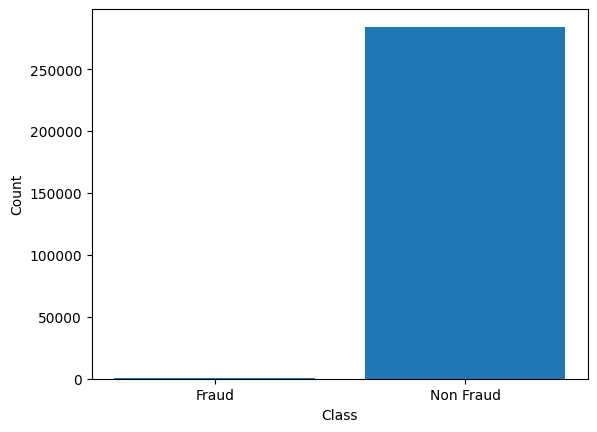

In [5]:
#let's print two columns with fraud and non fraud operations with matplotlib

fraud_df = data.filter(col('Class') == 1).count()
non_fraud_df = data.filter(col('Class') == 0).count()
print(non_fraud_df)
plt.bar(['Fraud', 'Non Fraud'], [fraud_df, non_fraud_df])
#add to axis labels
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


25/01/03 10:50:13 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[Row(Time=169142.0, V1=-1.92788332105459, V2=1.12565266367046, V3=-4.51833064132991, V4=1.74929253346589, V5=-1.56648729197754, V6=-2.01049423115212, V7=-0.882849830858081, V8=0.697211109261327, V9=-2.0649452874475, V10=-5.58779378195338, V11=2.1157951772133, V12=-5.4174240819973, V13=-1.23512263142388, V14=-6.66517689463338, V15=0.401700686738171, V16=-2.89782511671737, V17=-4.57052943365069, V18=-1.31514721385427, V19=0.391167040935071, V20=1.25296673470361, V21=0.778583978950071, V22=-0.319188818860513, V23=0.639418961153121, V24=-0.294885040380029, V25=0.537502535542985, V26=0.788395056528708, V27=0.292679966295281, V28=0.147967928722538, Amount=390.0, Class=1, Hour=22), Row(Time=169347.0, V1=1.37855899734127, V2=1.28938093711056, V3=-5.00424678441137, V4=1.4118498419441, V5=0.442580635567782, V6=-1.3265359338336, V7=-1.41316995590712, V8=0.248525467627175, V9=-1.12739593417081, V10=-3.23215317539514, V11=2.8584658156696, V12=-3.09691489835154, V13=-0.792532436177748, V14=-5.210140

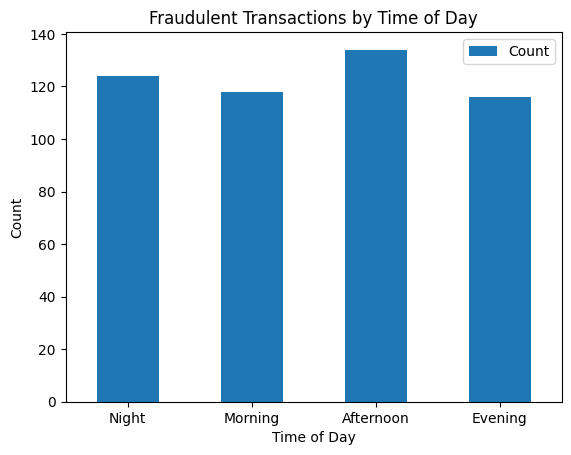

Night:  124
Morning:  118
Afternoon:  134
Evening:  116


In [5]:
from pyspark.sql.functions import when, col, expr
import matplotlib.pyplot as plt
import pandas as pd

# Add a column for hour of the day
fraud_df = fraud_df.where(col("Class") == 1)
fraud_df = fraud_df.withColumn("Hour", (col("Time") % 86400 / 3600).cast("integer"))

print(fraud_df.tail(5))

# Define time periods
fraud_df = fraud_df.withColumn(
    "TimePeriod",
    when((col("Hour") >= 0) & (col("Hour") < 6), "Night")
    .when((col("Hour") >= 6) & (col("Hour") < 12), "Morning")
    .when((col("Hour") >= 12) & (col("Hour") < 18), "Afternoon")
    .otherwise("Evening")
)

# Show the updated DataFrame
night = fraud_df.filter(col("TimePeriod") == "Night").count()
morning = fraud_df.filter(col("TimePeriod") == "Morning").count()
afternoon = fraud_df.filter(col("TimePeriod") == "Afternoon").count()
evening = fraud_df.filter(col("TimePeriod") == "Evening").count()

summary_df = pd.DataFrame(
    data=[night, morning, afternoon, evening],
    index=["Night", "Morning", "Afternoon", "Evening"],
    columns=["Count"],
)

summary_df.plot(kind="bar", title="Fraudulent Transactions by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

print("Night: ", night)
print("Morning: ", morning)
print("Afternoon: ", afternoon)
print("Evening: ", evening)


Перейдемо до використання класифікації для виявлення шахрайства в транзакціях. Використаємо oversampling для балансування даних та використаємо різні моделі класифікації для порівняння їх ефективності.

In [6]:
fraud_count = data.where(col("Class") == 1).count()
non_fraud_df = data.where(col("Class") == 0)

non_fraud_count = non_fraud_df.count()

n_samples_to_add = non_fraud_count - fraud_count
print(n_samples_to_add)
# Randomly sample the fraud transactions to add duplicates
fraud_oversampled_df = data.where(col("Class") == 1).sample(withReplacement=True, fraction=n_samples_to_add / fraud_count, seed=3445)

# Combine the oversampled fraud data with the non-fraud data
balanced_df = non_fraud_df.union(fraud_oversampled_df)

# Show the new counts for validation
balanced_fraud_count = balanced_df.filter(balanced_df['Class'] == 1).count()
balanced_non_fraud_count = balanced_df.filter(balanced_df['Class'] == 0).count()

print(f"Balanced Fraud transactions: {balanced_fraud_count}")
print(f"Balanced Non-fraud transactions: {balanced_non_fraud_count}")

283823
Balanced Fraud transactions: 283211
Balanced Non-fraud transactions: 284315


In [9]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define the feature columns (excluding 'Class' and 'time')
feature_columns = [col for col in balanced_df.columns if col not in ['Class', 'Time']]

# VectorAssembler to combine features into a single feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
lr = LogisticRegression(labelCol="Class", featuresCol="features")

# Create a pipeline that first indexes the categorical column and then performs classification
pipeline = Pipeline(stages=[assembler, lr])

# Split the data into training and test sets
train_df, _ = balanced_df.randomSplit([0.8, 0.2], seed=3445)

# Train the model
model = pipeline.fit(train_df)

# Make predictions on the test data
predictions = model.transform(data)

# Evaluate the model (you can use different metrics depending on your needs)
evaluator = BinaryClassificationEvaluator(labelCol="Class")
accuracy = evaluator.evaluate(predictions)
print(f"Model accuracy: {accuracy}")

# Show the confusion matrix
predictions.groupBy("Class", "prediction").count().show()



25/01/06 11:34:12 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Model accuracy: 0.9868822747413588


25/01/06 11:34:21 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----+----------+------+
|Class|prediction| count|
+-----+----------+------+
|    1|       0.0|    39|
|    0|       0.0|277809|
|    1|       1.0|   453|
|    0|       1.0|  6506|
+-----+----------+------+



In [5]:
print(train_df.columns)

NameError: name 'train_df' is not defined

In [10]:
# Use the random forest classifier

from pyspark.ml.classification import RandomForestClassifier

feature_columns = [col for col in balanced_df.columns if col not in ['Class', 'Time']]

# Vector assembler to combine features into a single feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define the random forest classifier with increased maxBins
rf = RandomForestClassifier(labelCol="Class", featuresCol="features")

# Create a pipeline that first indexes the categorical column and then performs classification
pipeline_rf = Pipeline(stages=[assembler, rf])

# Train the model
model_rf = pipeline_rf.fit(train_df)

# Make predictions on the test data
predictions_rf = model_rf.transform(data)

# Evaluate the model
accuracy_rf = evaluator.evaluate(predictions_rf)
print(f"Random forest accuracy: {accuracy_rf}")

# Show the confusion matrix
predictions_rf.groupBy("Class", "prediction").count().show()

Random forest accuracy: 0.9891309829115734
+-----+----------+------+
|Class|prediction| count|
+-----+----------+------+
|    1|       0.0|    45|
|    0|       0.0|283382|
|    1|       1.0|   447|
|    0|       1.0|   933|
+-----+----------+------+



+-----+----------+------+
|Class|prediction| count|
+-----+----------+------+
|    1|       0.0|    45|
|    0|       0.0|283382|
|    1|       1.0|   447|
|    0|       1.0|   933|
+-----+----------+------+



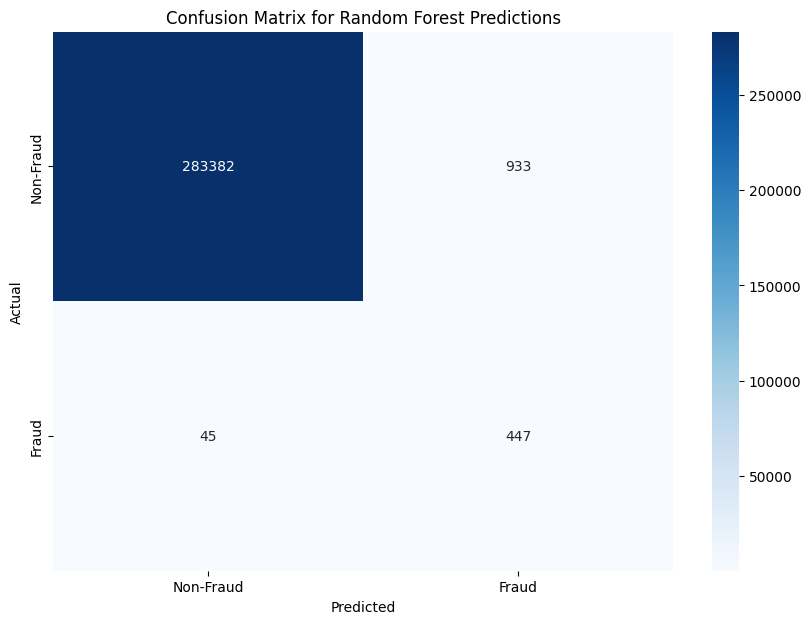

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Show the confusion matrix for Random Forest predictions
predictions_rf.groupBy("Class", "prediction").count().show()
import matplotlib.pyplot as plt

# Convert predictions to Pandas DataFrame
predictions_rf_pd = predictions_rf.select("Class", "prediction").toPandas()

# Compute confusion matrix
cm = confusion_matrix(predictions_rf_pd["Class"], predictions_rf_pd["prediction"])

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest Predictions")
plt.show()

Виконаємо підбір гіперпараметрів для кращої моделі та оцінимо її ефективність за допомогою метрик оцінки класифікації.

In [10]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

# Define the Random Forest classifier
rf = RandomForestClassifier(labelCol="Class", featuresCol="features")

# Define the parameter grid for hyperparameter tuning
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [20, 50, 100])  # Number of trees
             .addGrid(rf.maxDepth, [10, 15, 20])  # Max depth of the tree
             .addGrid(rf.maxBins, [32, 64, 128])  # Max bins used for splitting data
             .build())

# Set up the CrossValidator
evaluator = BinaryClassificationEvaluator(labelCol="Class")
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)  # Using 3-fold cross-validation

# Create the pipeline (with necessary feature transformation)
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
pipeline = Pipeline(stages=[assembler, crossval])


# Train the model using cross-validation
model = pipeline.fit(train_df)

# Make predictions
predictions = model.transform(data)

# Evaluate the model's performance
accuracy = evaluator.evaluate(predictions)
print(f"Model accuracy: {accuracy}")

25/01/05 19:08:11 WARN DAGScheduler: Broadcasting large task binary with size 1087.6 KiB
25/01/05 19:08:11 WARN DAGScheduler: Broadcasting large task binary with size 1177.5 KiB
25/01/05 19:08:16 WARN DAGScheduler: Broadcasting large task binary with size 1052.9 KiB
25/01/05 19:08:16 WARN DAGScheduler: Broadcasting large task binary with size 1138.7 KiB
25/01/05 19:08:21 WARN DAGScheduler: Broadcasting large task binary with size 1029.3 KiB
25/01/05 19:08:21 WARN DAGScheduler: Broadcasting large task binary with size 1109.5 KiB
25/01/05 19:08:25 WARN DAGScheduler: Broadcasting large task binary with size 1087.6 KiB
25/01/05 19:08:25 WARN DAGScheduler: Broadcasting large task binary with size 1177.5 KiB
25/01/05 19:08:26 WARN DAGScheduler: Broadcasting large task binary with size 1251.7 KiB
25/01/05 19:08:26 WARN DAGScheduler: Broadcasting large task binary with size 1311.2 KiB
25/01/05 19:08:26 WARN DAGScheduler: Broadcasting large task binary with size 1360.3 KiB
25/01/05 19:08:26 WAR

Model accuracy: 1.0


+-----+----------+-----+
|Class|prediction|count|
+-----+----------+-----+
|    0|       0.0|56556|
|    0|       1.0|    6|
|    1|       1.0|56563|
+-----+----------+-----+



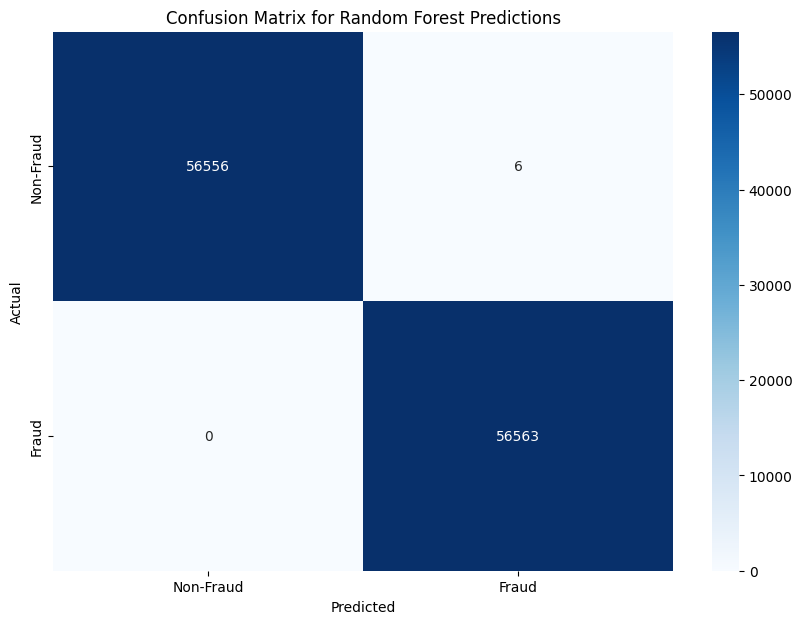

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Show the confusion matrix for Random Forest predictions
predictions.groupBy("Class", "prediction").count().show()
import matplotlib.pyplot as plt

# Convert predictions to Pandas DataFrame
predictions_pd = predictions.select("Class", "prediction").toPandas()

# Compute confusion matrix
cm = confusion_matrix(predictions_pd["Class"], predictions_pd["prediction"])

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest Predictions")
plt.show()

+-----+----------+------+
|Class|prediction| count|
+-----+----------+------+
|    0|       0.0|284301|
|    1|       1.0|   492|
|    0|       1.0|    14|
+-----+----------+------+



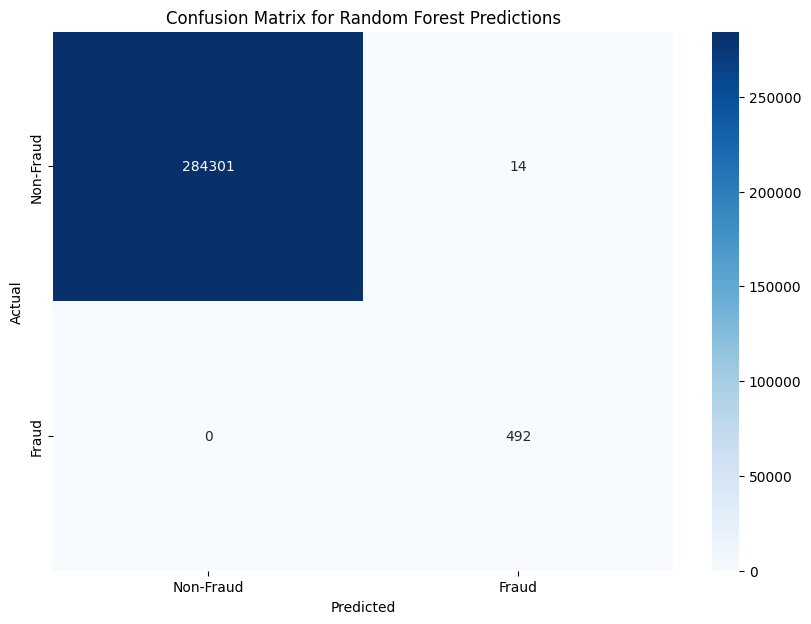

Number of trees: 20
Max depth: 20
Max bins: 32
Feature importances: (29,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28],[0.009331473093421624,0.006095584903679538,0.06761475276167499,0.08004219079915045,0.005312598525372164,0.0062988178428226875,0.0064052976259681765,0.012252770856312776,0.00844140893113566,0.15514188310859964,0.09854180716424132,0.14959426102302617,0.010619810702790543,0.164894317023371,0.008067679141747358,0.013074405640958273,0.08785537263153471,0.008634370414406574,0.013080968338661859,0.007736382196163164,0.022956289492029658,0.00624660695680021,0.006327224377191655,0.005936601172366593,0.004943325269653845,0.0077557721237048755,0.008629175147479563,0.006394357196231006,0.011774495539503377])


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

predictions = model.transform(data)
predictions.groupBy("Class", "prediction").count().show()

# Convert predictions to Pandas DataFrame
predictions_pd = predictions.select("Class", "prediction").toPandas()

# Compute confusion matrix
cm = confusion_matrix(predictions_pd["Class"], predictions_pd["prediction"])

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest Predictions")
plt.show()

# Print the best model's hyperparameters
best_model = model.stages[-1].bestModel
print(f"Number of trees: {best_model.getNumTrees}")
print(f"Max depth: {best_model.getOrDefault('maxDepth')}")
print(f"Max bins: {best_model.getOrDefault('maxBins')}")

Виконаємо перевірку методу поєднання IQR та RandomForest для виявлення шахрайства в транзакціях.

In [29]:
from fraud_detection_lib import FraudDetectionLib

fraud_detection_lib = FraudDetectionLib()
fraud_detection_lib.calculate_iqr_bounds(data=data, features=["Amount", "V11", "V4", "V2"])

# Filter the data based on the IQR bounds
outliers_df = fraud_detection_lib.iqr_detection(data=data, features=["Amount", "V11", "V4", "V2"])

outliers = outliers_df[outliers_df['is_anomaly'] == 1]

prediction = model.transform(outliers)


+-----+----------+----------+-----+
|Class|prediction|is_anomaly|count|
+-----+----------+----------+-----+
|    0|       1.0|         1|    6|
|    0|       0.0|         1|47876|
|    1|       1.0|         1|  402|
+-----+----------+----------+-----+



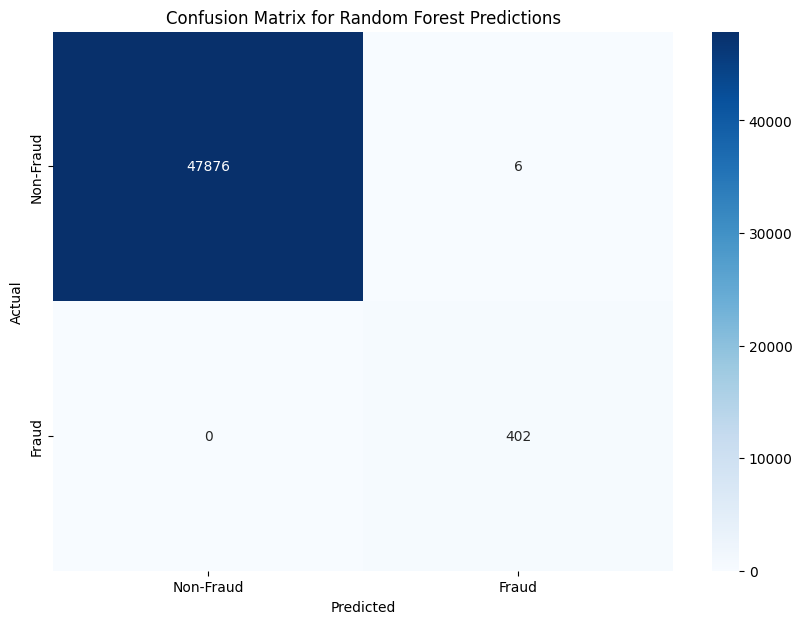

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Show the confusion matrix for Random Forest predictions
prediction.groupBy("Class", "prediction", "is_anomaly").count().show()
import matplotlib.pyplot as plt

# Convert predictions to Pandas DataFrame
predictions_pd = prediction.select("Class", "prediction").toPandas()

# Compute confusion matrix
cm = confusion_matrix(predictions_pd["Class"], predictions_pd["prediction"])

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest Predictions")
plt.show()